In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from utils import *

In [2]:
tex_fonts = {
    #source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    #"axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble': r"\usepackage{amsmath}"
}

In [9]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Display the GeoDataFrame to ensure it's correct
print(gdf.head())

                    LSOA21NM   centroid_x   centroid_y  c_percent asian  \
0        City of London 001A  532151.1942  181615.2014         0.107191   
1        City of London 001B  532443.6860  181645.7249         0.130592   
2        City of London 001C  532207.0148  182030.1296         0.094913   
3        City of London 001E  533618.3485  181157.3543         0.321526   
4  Barking and Dagenham 016A  544934.3697  184297.5465         0.479675   

   c_percent black  c_percent mixed  c_percent white  c_percent sikh  \
0         0.007463         0.037992         0.801221        0.000000   
1         0.007937         0.043290         0.782107        0.000000   
2         0.034739         0.062655         0.741315        0.001860   
3         0.108084         0.071753         0.385104        0.000000   
4         0.108401         0.037940         0.327913        0.036295   

   c_percent hindu  c_percent christian  ...  o_opioids_quantity_per_capita  \
0         0.026441             0.3457

# 测试不同网络 -- 重力模型，距离加权？

In [12]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 两层网络

C:\Users\0\AppData\Local\Temp\ipykernel_18352\2209858293.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


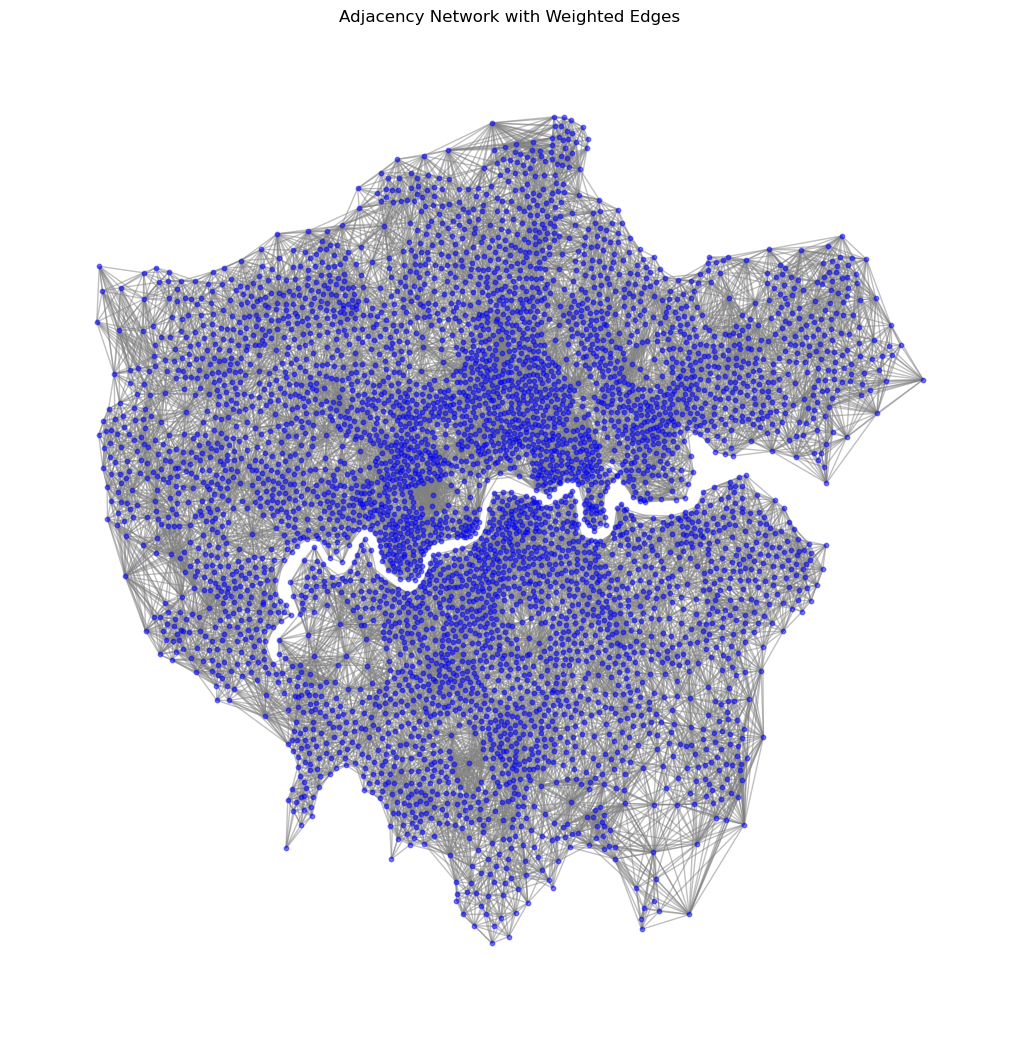

In [13]:
# 读取CSV文件
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建GeoDataFrame
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算几何中心点
gdf['geo_centroid'] = gdf.centroid
coords = np.array(list(zip(gdf.geo_centroid.x, gdf.geo_centroid.y)))

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 计算中心点之间的距离
dist_matrix = distance_matrix(coords, coords)

# 创建邻居关系字典
first_level_neighbors = {i: [] for i in range(len(gdf))}
second_level_neighbors = {i: set() for i in range(len(gdf))}

for idx, row in neighbors.iterrows():
    first_level_neighbors[row.name].append(row['index_right'])

# 查找第二层邻居
for i in first_level_neighbors:
    for first_neighbor in first_level_neighbors[i]:
        second_level_neighbors[i].update(first_level_neighbors[first_neighbor])
    second_level_neighbors[i].discard(i)
    second_level_neighbors[i].difference_update(first_level_neighbors[i])

# 构建网络并根据距离倒数设置权重
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加第一层邻居的边，权重高
for idx, neighbors in first_level_neighbors.items():
    for neighbor in neighbors:
        G.add_edge(idx, neighbor, weight=1 / dist_matrix[idx][neighbor])

# 添加第二层邻居的边，权重低
for idx, neighbors in second_level_neighbors.items():
    for neighbor in neighbors:
        G.add_edge(idx, neighbor, weight=0.5 / dist_matrix[idx][neighbor])  # 权重较低

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()


## 单层网络

C:\Users\0\AppData\Local\Temp\ipykernel_30032\612648604.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


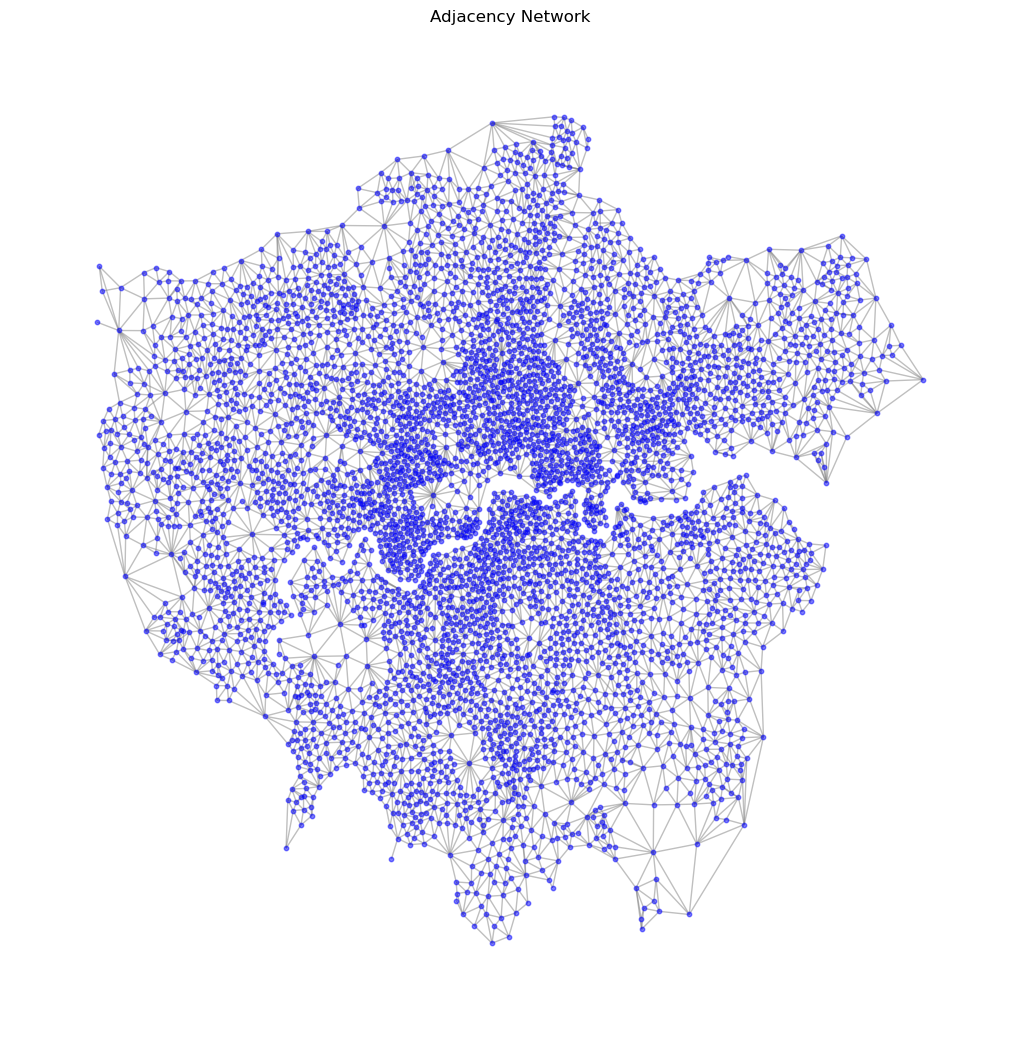

In [76]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

# 变量选择问题 -- 固定控制变量（所有的年龄段） + 寻找尽可能低的VIF变量组

In [14]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    'c_percent occupancy rating rooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    'c_percent married or in a registered civil partnership in a registered civil partnership same sex',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   36.848437
1                       c_percent Aged 15 to 19 years   16.166459
2                       c_percent Aged 20 to 24 years   32.896059
3                       c_percent Aged 25 to 29 years   32.300185
4                       c_percent Aged 30 to 34 years   52.606991
5                       c_percent Aged 35 to 39 years   62.327100
6                       c_percent Aged 40 to 44 years   62.851638
7                                     c_percent mixed   21.101573
8                                     c_percent white  124.986231
9               c_percent 2. Professional occupations   49.941544
10                                      c_pop_density    6.511979
11                                             e_ndvi   77.233460
12                                            e_water    5.932383
13                                            e_trees

In [63]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent mixed',
    # 'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 填充NaN值
fixed_features.fillna(fixed_features.mean(), inplace=True)

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# 初始化VIF DataFrame
vif_df = calculate_vif(fixed_features)
print("Initial VIF for fixed features:")
print(vif_df)

# 提取所有 'c' 开头的变量
c_features_columns = [col for col in gdf.columns if col.startswith('c_') and col not in fixed_columns]
c_features = gdf[c_features_columns].apply(pd.to_numeric, errors='coerce')

# 提取所有 'e' 开头的变量
e_features_columns = [col for col in gdf.columns if col.startswith('e_') and col not in fixed_columns]
e_features = gdf[e_features_columns].apply(pd.to_numeric, errors='coerce')

# 初步筛选：移除与目标变量相关性较低的自变量（相关性绝对值小于0.1）
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)

corr_with_target = c_features.corrwith(target).abs()
relevant_features = corr_with_target[corr_with_target > 0.1].index
c_features = c_features[relevant_features]

# 计算相关矩阵并删除相关性高于0.9的变量
correlation_matrix = c_features.corr().abs()
upper_triangle_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# 找出高相关性变量
high_corr_var = [column for column in upper_triangle_matrix.columns if any(upper_triangle_matrix[column] > 0.9)]

# 删除高相关性变量
c_features = c_features.drop(columns=high_corr_var)

# 合并固定变量和筛选后的 'c' 和 'e' 开头的变量
all_additional_features = pd.concat([c_features, e_features], axis=1)
all_additional_features.fillna(all_additional_features.mean(), inplace=True)

# 当前特征集
current_features = fixed_features.copy()

# 尝试添加每个额外的特征
for column in all_additional_features.columns:
    current_features[column] = all_additional_features[column]
    vif_df = calculate_vif(current_features)
    
    if vif_df['VIF'].max() > 50:
        current_features.drop(columns=[column], inplace=True)
    else:
        print(f"Added {column}, VIFs are:")
        print(vif_df)

print("Final selected features with VIFs:")
print(calculate_vif(current_features))

# 保存最终的特征集
final_features = current_features.copy()

# 转换为Tensor
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(current_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)

# 将 NetworkX 图转换为 PyTorch Geometric 数据
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets


Initial VIF for fixed features:
                                 Variable        VIF
0           c_percent Aged 10 to 14 years  14.738088
1           c_percent Aged 15 to 19 years  14.212176
2           c_percent Aged 20 to 24 years  13.329516
3           c_percent Aged 25 to 29 years  16.044030
4                         c_percent mixed   9.853347
5   c_percent 2. Professional occupations  12.187371
6                           c_pop_density   5.277845
7                                 e_water   5.221332
8                                 e_trees   4.490753
9                                 e_grass   5.083849
10                                 e_bare  13.591397
Added c_percent asian, VIFs are:
                                 Variable        VIF
0           c_percent Aged 10 to 14 years  15.799744
1           c_percent Aged 15 to 19 years  14.367467
2           c_percent Aged 20 to 24 years  13.448907
3           c_percent Aged 25 to 29 years  16.159152
4                         c_percen

# GIN测试

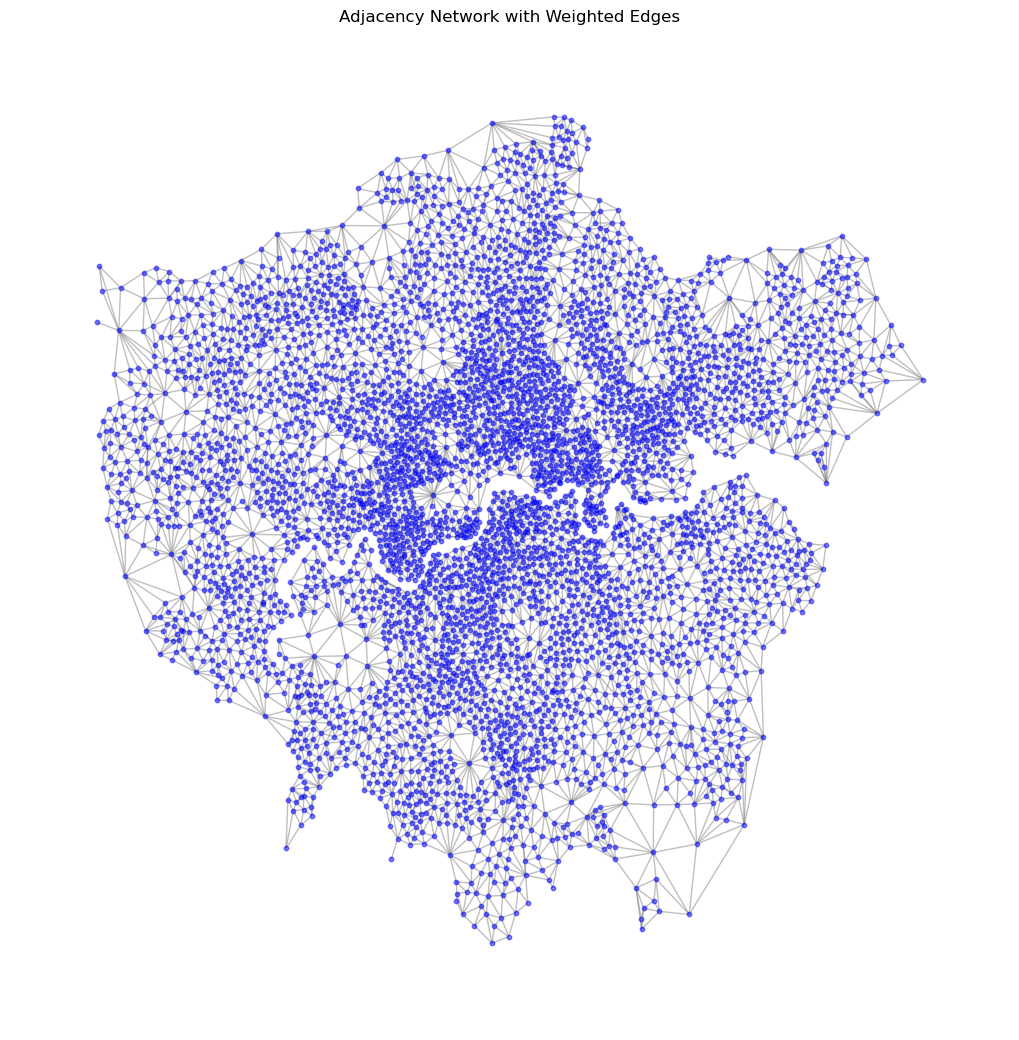

In [77]:
# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()

## 两层网络 GIN

Best params: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 32, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 72.9240
MSE: 59.2376
RMSE: 7.6966
MAE: 5.8995
R²: 0.6408


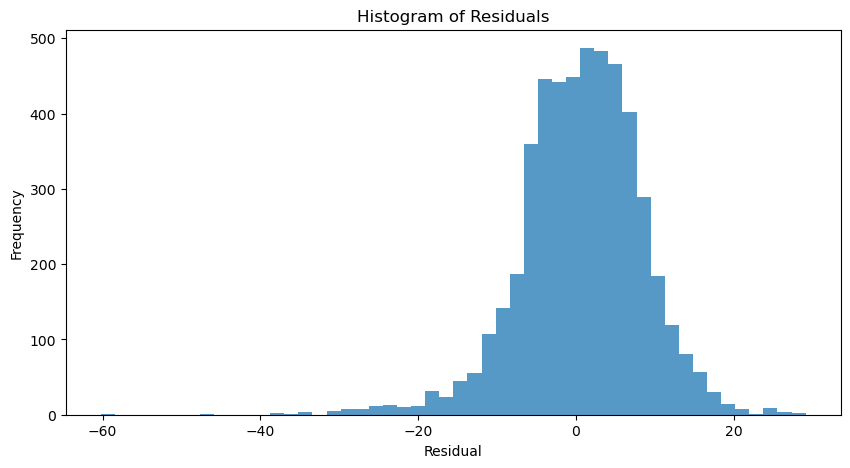

In [72]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## 原始GIN

Best params: {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 77.4922
MSE: 69.5004
RMSE: 8.3367
MAE: 6.2843
R²: 0.5786


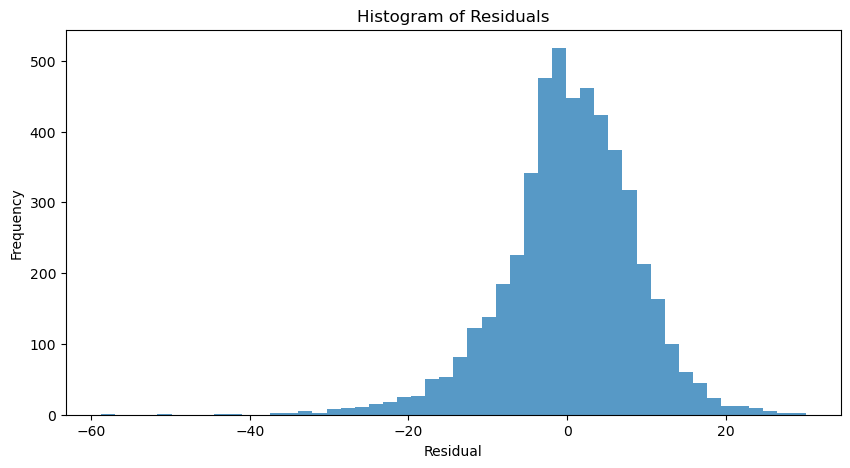

In [79]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 泛化性

In [260]:
import torch
from torch_geometric.utils import from_networkx
import numpy as np
import networkx as nx

# 识别Southwark区域
is_southwark = gdf['LSOA21NM'].str.contains('Bromley|Camden|Southwark|Richmond')

# 划分训练集和测试集
train_indices = np.where(~is_southwark)[0]
test_indices = np.where(is_southwark)[0]

# 构建新的NetworkX图，包括所有相关节点
train_G = nx.Graph()
train_relevant_nodes = set(train_indices)

# 找出所有训练节点的直接邻居和第二层邻居，并添加到训练图中
for idx in train_indices:
    for neighbor in G.neighbors(idx):
        train_relevant_nodes.add(neighbor)
        for second_neighbor in G.neighbors(neighbor):
            train_relevant_nodes.add(second_neighbor)

# 添加相关节点到训练图中
for idx in train_relevant_nodes:
    train_G.add_node(idx, pos=G.nodes[idx]['pos'])
    train_G.nodes[idx]['x'] = final_features_tensor[idx].tolist()

# 添加边，包括所有区域节点的关系
for idx in train_relevant_nodes:
    for neighbor in G.neighbors(idx):
        if neighbor in train_relevant_nodes:
            train_G.add_edge(idx, neighbor, weight=G.edges[idx, neighbor]['weight'])

# 构建Southwark区域的测试图，包括所有相关节点
test_G = nx.Graph()
test_relevant_nodes = set(test_indices)

# 找出所有测试节点的直接邻居和第二层邻居，并添加到测试图中
for idx in test_indices:
    for neighbor in G.neighbors(idx):
        test_relevant_nodes.add(neighbor)
        for second_neighbor in G.neighbors(neighbor):
            test_relevant_nodes.add(second_neighbor)

# 添加相关节点到测试图中
for idx in test_relevant_nodes:
    test_G.add_node(idx, pos=G.nodes[idx]['pos'])
    test_G.nodes[idx]['x'] = final_features_tensor[idx].tolist()

# 添加边，包括Southwark区域边缘节点与其他区域节点的关系
for idx in test_relevant_nodes:
    for neighbor in G.neighbors(idx):
        if neighbor in test_relevant_nodes:
            test_G.add_edge(idx, neighbor, weight=G.edges[idx, neighbor]['weight'])

# 确保所有节点的索引都在有效范围内
train_relevant_nodes = list(train_relevant_nodes)
test_relevant_nodes = list(test_relevant_nodes)

# 重建索引映射
train_node_mapping = {node: i for i, node in enumerate(train_relevant_nodes)}
test_node_mapping = {node: i for i, node in enumerate(test_relevant_nodes)}

# 重新映射训练图中的边
train_edge_index = []
for idx in train_relevant_nodes:
    for neighbor in train_G.neighbors(idx):
        if neighbor in train_relevant_nodes:
            train_edge_index.append([train_node_mapping[idx], train_node_mapping[neighbor]])

# 重新映射测试图中的边
test_edge_index = []
for idx in test_relevant_nodes:
    for neighbor in test_G.neighbors(idx):
        if neighbor in test_relevant_nodes:
            test_edge_index.append([test_node_mapping[idx], test_node_mapping[neighbor]])

# 将训练数据转换为 PyTorch Geometric 数据
train_data = from_networkx(train_G)
train_data.x = torch.tensor([train_G.nodes[idx]['x'] for idx in train_relevant_nodes], dtype=torch.float)
train_data.y = torch.tensor([targets[idx] for idx in train_relevant_nodes], dtype=torch.float).unsqueeze(1)
train_data.edge_index = torch.tensor(train_edge_index, dtype=torch.long).t().contiguous()

# 将测试数据转换为 PyTorch Geometric 数据
test_data = from_networkx(test_G)
test_data.x = torch.tensor([test_G.nodes[idx]['x'] for idx in test_relevant_nodes], dtype=torch.float)
test_data_y = [targets[idx].item() if idx in test_indices else 0 for idx in test_relevant_nodes]
test_data_y = torch.tensor(test_data_y, dtype=torch.float).unsqueeze(1)
test_data.edge_index = torch.tensor(test_edge_index, dtype=torch.long).t().contiguous()
test_data.y = test_data_y

# 打印检查数据集信息
print("Train data:", train_data)
print("Test data:", test_data)


Train data: Data(x=[4966, 43], edge_index=[2, 96886], pos=[4966, 2], weight=[96886], y=[4966, 1])
Test data: Data(x=[1616, 43], edge_index=[2, 29196], pos=[1616, 2], weight=[29196], y=[1616, 1])


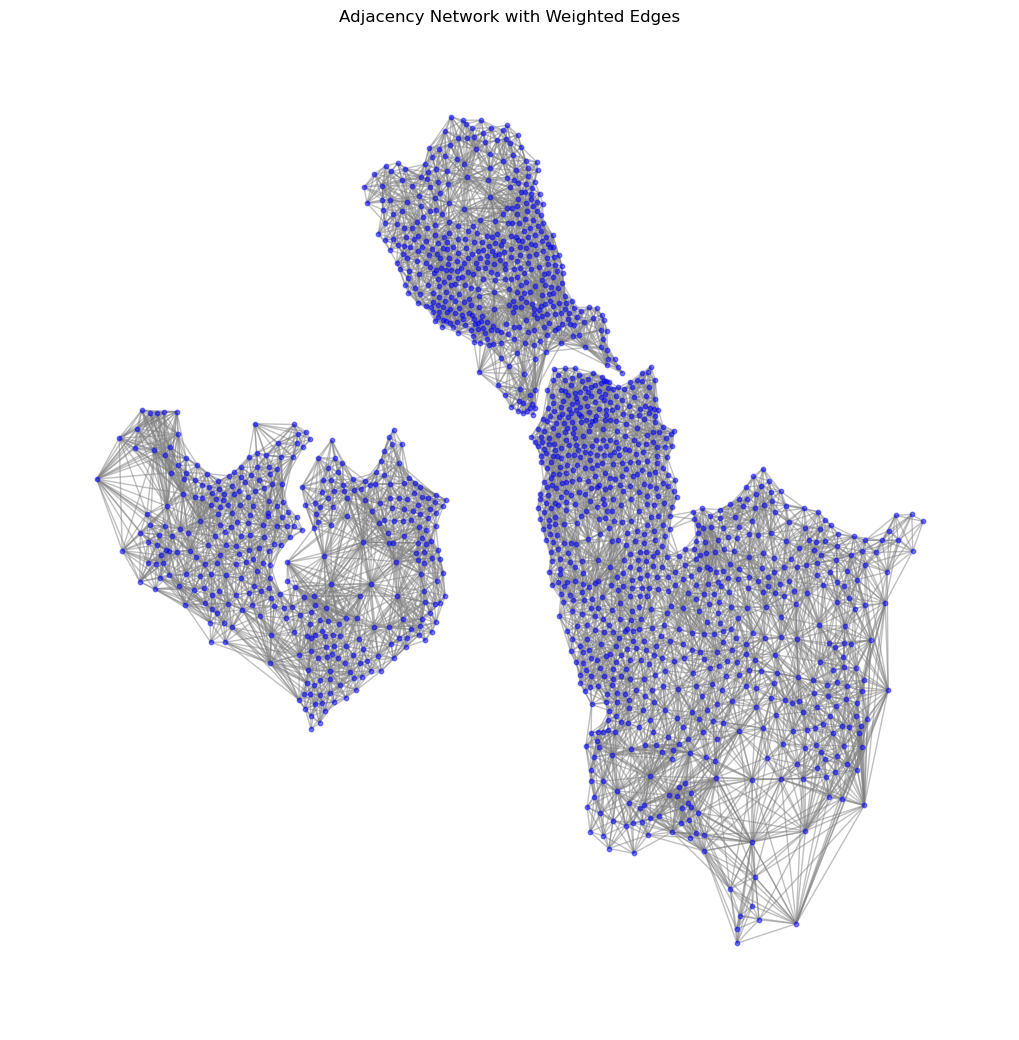

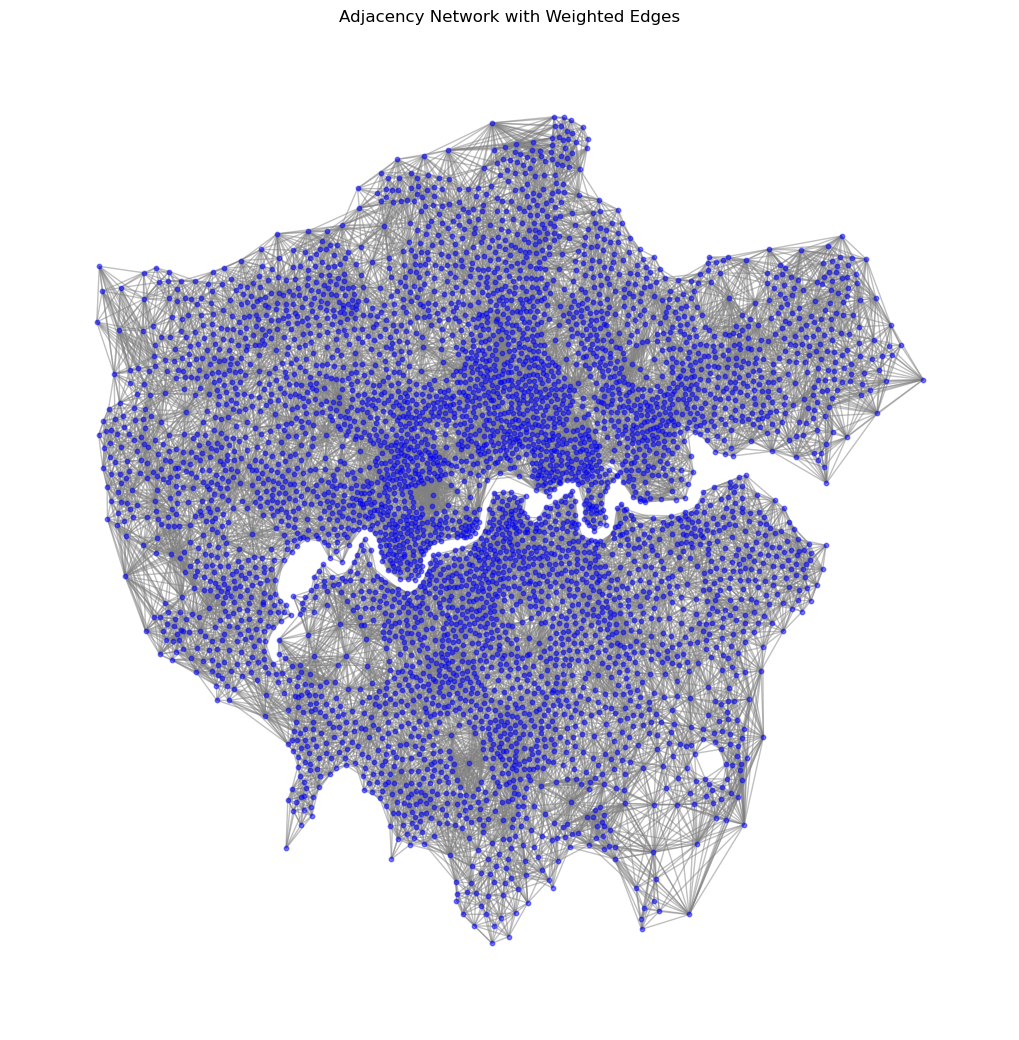

In [261]:
# 可视化邻接关系
pos = nx.get_node_attributes(test_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(test_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()
# 可视化邻接关系
pos = nx.get_node_attributes(train_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(train_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 10, Loss: 644.9631
Epoch 20, Loss: 631.9143
Epoch 30, Loss: 621.8604
Epoch 40, Loss: 612.1251
Epoch 50, Loss: 599.8106
Epoch 60, Loss: 590.0594
Epoch 70, Loss: 578.4055
Epoch 80, Loss: 568.0789
Epoch 90, Loss: 556.5880
Epoch 100, Loss: 545.1765
Epoch 110, Loss: 533.7721
Epoch 120, Loss: 521.0552
Epoch 130, Loss: 507.6331
Epoch 140, Loss: 491.8115
Epoch 150, Loss: 478.8817
Epoch 160, Loss: 466.6978
Epoch 170, Loss: 452.7382
Epoch 180, Loss: 440.3826
Epoch 190, Loss: 424.3127
Epoch 200, Loss: 412.0962
Epoch 10, Loss: 661.7466
Epoch 20, Loss: 653.3281
Epoch 30, Loss: 646.0606
Epoch 40, Loss: 639.2044
Epoch 50, Loss: 632.1234
Epoch 60, Loss: 626.4093
Epoch 70, Loss: 620.1559
Epoch 80, Loss: 614.0615
Epoch 90, Loss: 607.0172
Epoch 100, Loss: 600.9885
Epoch 110, Loss: 594.8198
Epoch 120, Loss: 587.9088
Epoch 130, Loss: 582.1113
Epoch 140, Loss: 574.9741
Epoch 150, Loss: 568.5035
Epoch 160, Loss: 560.1450
Epoch 170, Loss: 553.8560
Epoch 180, Loss: 546.2632
Epoch 190, Loss: 538.8038
Epoc

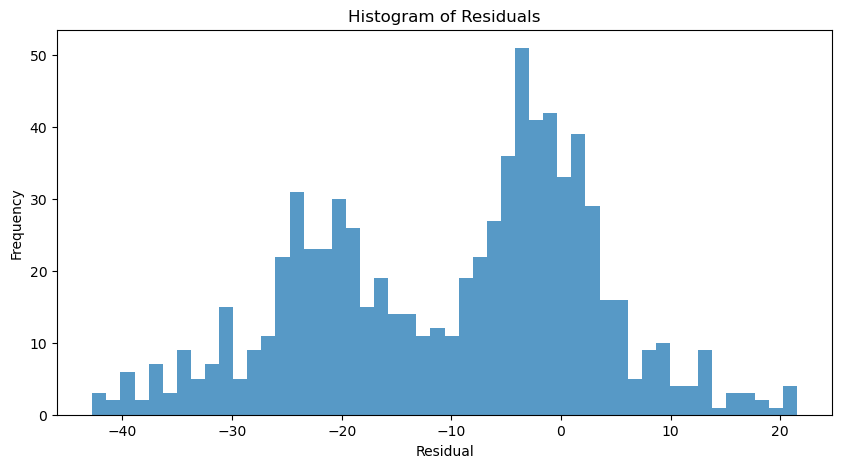

In [235]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 定义改进后的GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden1)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden2)
        
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


# 环境变量创建 -- 用地类型，不透水面积 -- 坡度

MSE: 34.8743
RMSE: 5.9054
MAE: 4.1301
R²: 0.7899


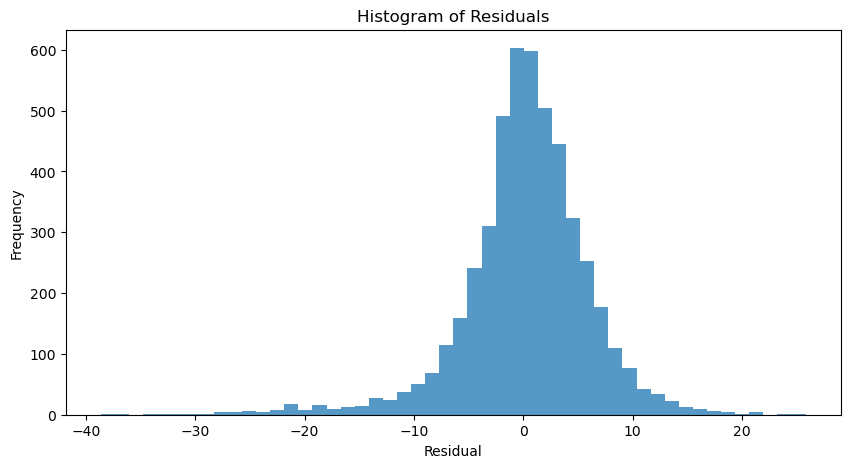

In [236]:
# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(train_data)
    residuals = train_data.y - pred

# 计算评估指标
y_true = train_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

MSE: 36.5888
RMSE: 6.0489
MAE: 4.2402
R²: 0.7781


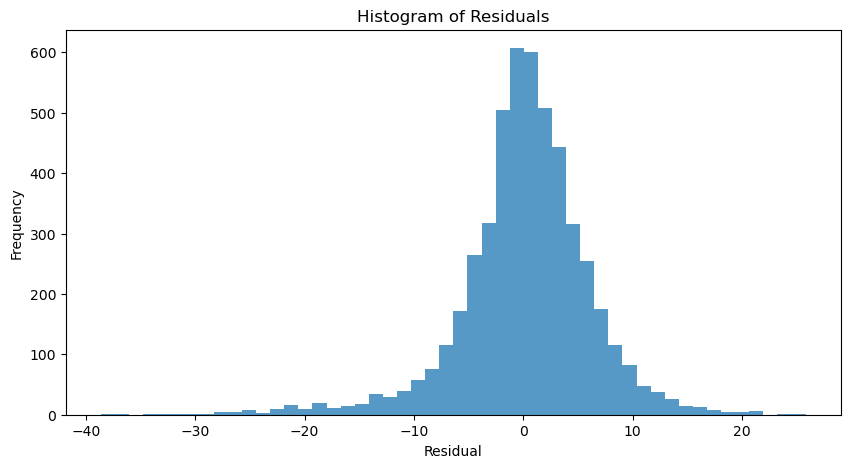

In [237]:
# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 用第二种构建方法（包括邻居的方法） -- 似乎有子模式？

In [238]:
best_params

{'lr': 0.005,
 'weight_decay': 0.005,
 'hidden1': 64,
 'hidden2': 64,
 'dropout': 0.3}

MSE: 393.6102
RMSE: 19.8396
MAE: 15.3751
R²: -0.9511


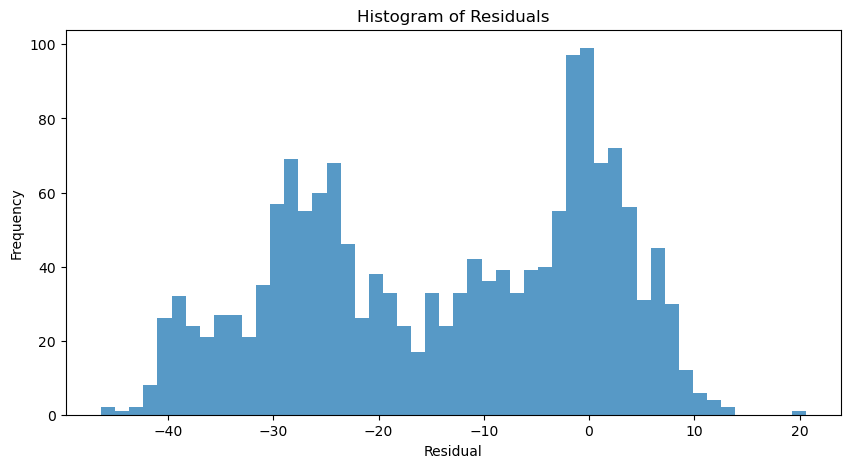

In [262]:
# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 补一个，用第一种方法直白的

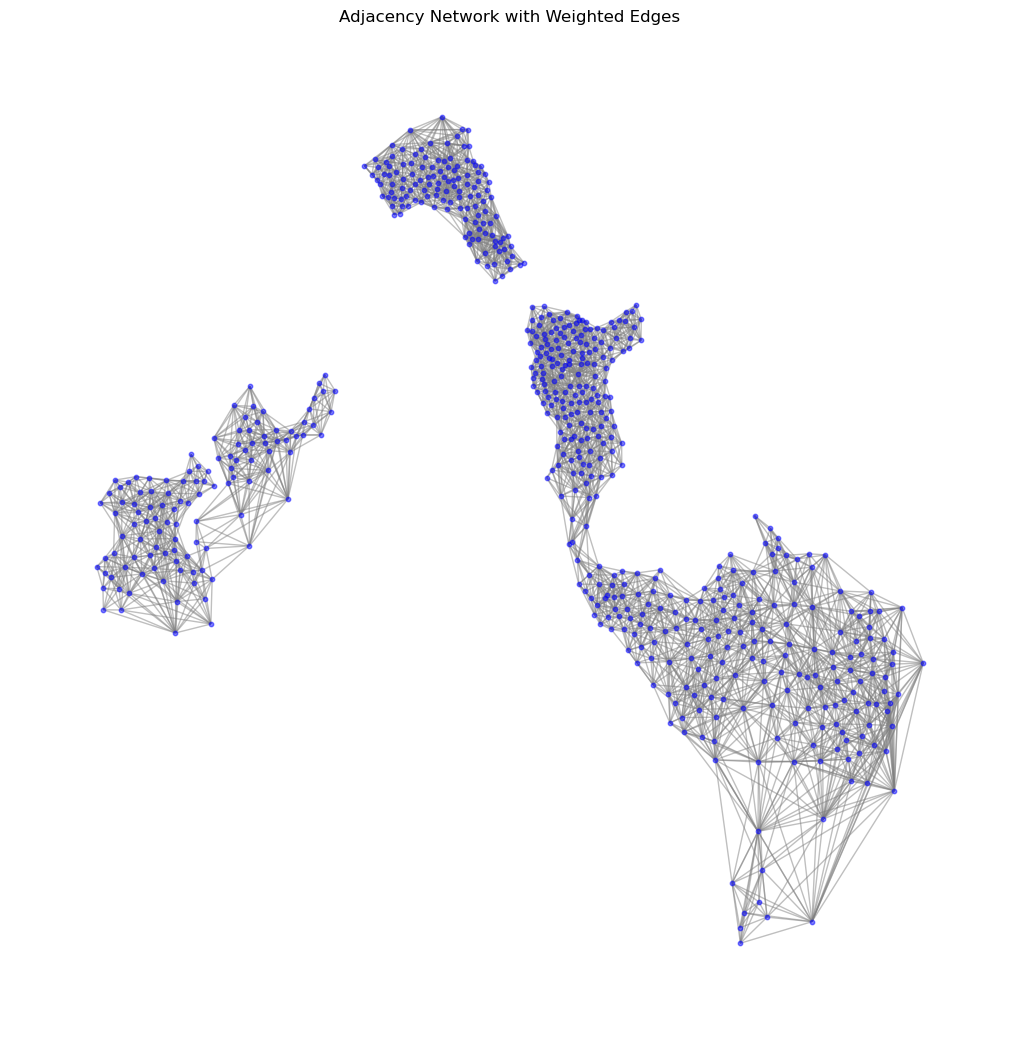

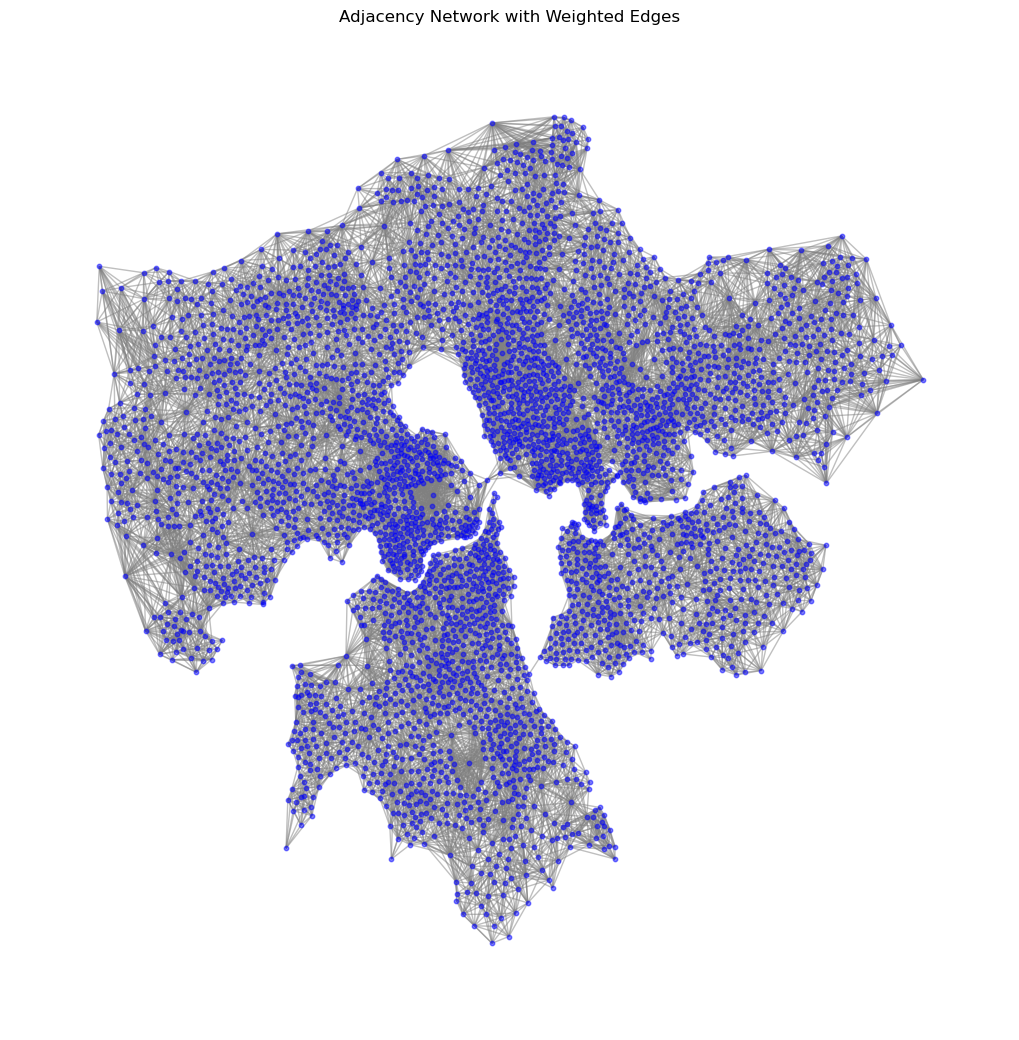

Train data: Data(edge_index=[2, 83516], pos=[4377, 2], weight=[83516], x=[4377, 43], y=[4377, 1])
Test data: Data(edge_index=[2, 9864], pos=[617, 2], weight=[9864], x=[617, 43], y=[617, 1])


In [15]:
# 识别区域
is_southwark = gdf['LSOA21NM'].str.contains('Bromley|Camden|Southwark|Richmond')

# 划分训练集和测试集
train_features = final_features_tensor[~is_southwark]
test_features = final_features_tensor[is_southwark]
train_targets = targets[~is_southwark]
test_targets = targets[is_southwark]

# 重新索引训练数据以便与Graph中的节点索引一致
train_indices = np.where(~is_southwark)[0]
test_indices = np.where(is_southwark)[0]

# 构建新的NetworkX图，仅包括训练数据中的节点
train_G = nx.Graph()

# 添加训练数据中的节点
for idx in train_indices:
    train_G.add_node(idx, pos=G.nodes[idx]['pos'])

# 构建训练数据的邻接关系
for idx in train_indices:
    for neighbor in G.neighbors(idx):
        if neighbor in train_indices:
            train_G.add_edge(idx, neighbor, weight=G.edges[idx, neighbor]['weight'])

# 构建测试数据的邻接关系
test_G = nx.Graph()
for idx in test_indices:
    test_G.add_node(idx, pos=G.nodes[idx]['pos'])
    for neighbor in G.neighbors(idx):
        if neighbor in test_indices:
            test_G.add_edge(idx, neighbor, weight=G.edges[idx, neighbor]['weight'])

# 将训练数据转换为 PyTorch Geometric 数据
train_data = from_networkx(train_G)
train_data.x = train_features
train_data.y = train_targets

# 将测试数据转换为 PyTorch Geometric 数据
test_data = from_networkx(test_G)
test_data.x = test_features
test_data.y = test_targets

# 可视化邻接关系
pos = nx.get_node_attributes(test_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(test_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()
# 可视化邻接关系
pos = nx.get_node_attributes(train_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(train_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()

# 打印检查数据集信息
print("Train data:", train_data)
print("Test data:", test_data)

Epoch 10, Loss: 575.2046
Epoch 20, Loss: 496.1431
Epoch 30, Loss: 410.5754
Epoch 40, Loss: 318.1030
Epoch 50, Loss: 231.8036
Epoch 60, Loss: 157.6740
Epoch 70, Loss: 108.4716
Epoch 80, Loss: 85.9055
Epoch 90, Loss: 75.9318
Epoch 100, Loss: 69.5121
Epoch 110, Loss: 67.0777
Epoch 120, Loss: 64.0625
Epoch 130, Loss: 65.8237
Epoch 140, Loss: 62.5023
Epoch 150, Loss: 61.5463
Epoch 160, Loss: 62.5852
Epoch 170, Loss: 61.1988
Early stopping at epoch 173
Epoch 10, Loss: 655.8361
Epoch 20, Loss: 646.2047
Epoch 30, Loss: 639.9568
Epoch 40, Loss: 634.3611
Epoch 50, Loss: 629.8039
Epoch 60, Loss: 625.3589
Epoch 70, Loss: 620.7957
Epoch 80, Loss: 615.8500
Epoch 90, Loss: 611.1271
Epoch 100, Loss: 607.4573
Epoch 110, Loss: 602.6561
Epoch 120, Loss: 597.0300
Epoch 130, Loss: 591.6106
Epoch 140, Loss: 585.7797
Epoch 150, Loss: 580.2184
Epoch 160, Loss: 572.6330
Epoch 170, Loss: 566.0335
Epoch 180, Loss: 559.0053
Epoch 190, Loss: 552.3246
Epoch 200, Loss: 542.9565
Epoch 10, Loss: 646.3124
Epoch 20, Los

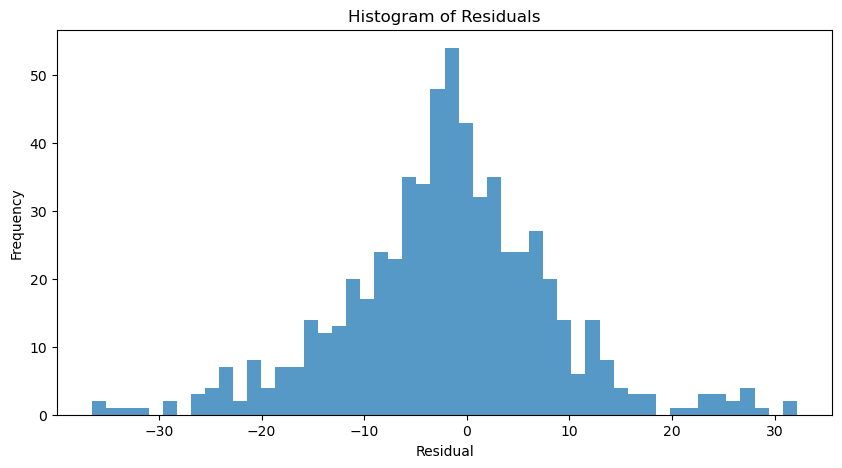

In [266]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 定义改进后的GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden1)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden2)
        
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [267]:
best_params

{'lr': 0.005,
 'weight_decay': 0.005,
 'hidden1': 128,
 'hidden2': 64,
 'dropout': 0.3}

MSE: 30.5015
RMSE: 5.5228
MAE: 3.7009
R²: 0.8078


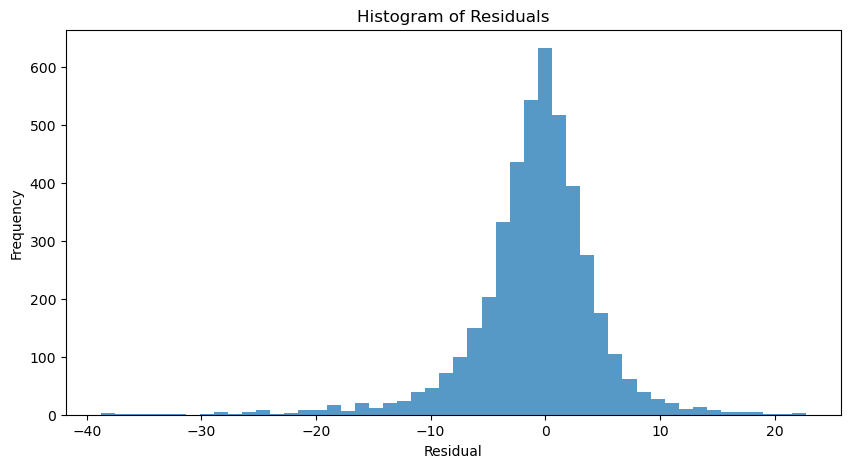

In [268]:
# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(train_data)
    residuals = train_data.y - pred

# 计算评估指标
y_true = train_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

MSE: 40.5271
RMSE: 6.3661
MAE: 4.2792
R²: 0.7543


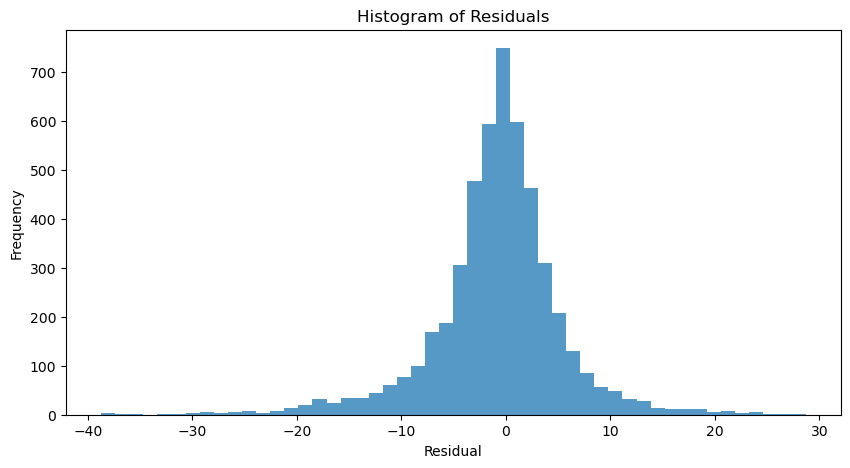

In [269]:
# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()